In [1]:
from collections import defaultdict, deque
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.metrics import mean_squared_error
from surprise import accuracy, Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, train_test_split
import surprise as sp

## IMPORT DATA (Initial Investigation)

In [2]:
print(os.listdir("netflix-prize-data"))

['movie_titles.csv', 'qualifying.txt', 'combined_data_2.txt', 'combined_data_3.txt', 'combined_data_1.txt', 'combined_data_4.txt', 'README', 'netflix.txt', 'probe.txt']


#### Import 1st testing dataset 'combined_data_1.txt'
Roughly 24,000,000 entries. Each entry is customerId, rating, and year of rating.
Movie IDs are to be mapped to every user rating for creating user-movie matrix later

In [3]:
training_1 = pd.read_csv('netflix-prize-data/combined_data_1.txt',
                         header = None,
                         names=['user_id','rating','date'], usecols = [0,1,2])
print(training_1.shape)
print(training_1.head(5))

(24058263, 3)
   user_id  rating        date
0       1:     NaN         NaN
1  1488844     3.0  2005-09-06
2   822109     5.0  2005-05-13
3   885013     4.0  2005-10-19
4    30878     4.0  2005-12-26


#### Import 'movie_titles' table
Roughly 18000 entries. Each entry is movie_id, year_released and movie name

In [4]:
movie_titles = pd.read_csv('netflix-prize-data/movie_titles.csv',
                           encoding = 'ISO-8859-1',
                           header = None, 
                           names = ['movie_id', 'year', 'name']).set_index('movie_id')
print(movie_titles.shape)
movie_titles.sample(5)

(17770, 2)


,year,name
movie_id,,
6173,1976.0,The Seven Percent Solution
5779,1999.0,The Terrorist
2210,1999.0,Directors: Ron Howard
1989,2000.0,Ablaze
16220,2002.0,L'Auberge Espagnole


#### Model traning data. Map the movie id to each rating

In [5]:
temp_movieid_df = training_1[training_1['rating'].isna()]['user_id'].reset_index()
# here in the temp: index is user's id and user_id is actually movie_id (4499 rows)


movie_index = []
for index, movieid in temp_movieid_df.values: #loop through above temp df, use index and user_id(movie_id)
    movie_index.append([index,int(movieid[:-1])]) # map each user to the movie
movie_index_shift = deque(movie_index) #shift item [0,1] to the back
movie_index_shift.rotate(-1)
movie_index_shift

df_to_concat = []

# exmaple of following zip
# [0, 1] [548, 2]
# [548, 2] [694, 3]
# [694, 3] [2707, 4]

for [index_noshift, movie_id], [index_shift, next_movie_id] in zip(movie_index, movie_index_shift):

    if index_noshift<index_shift:
        temp_df = training_1.loc[index_noshift+1:index_shift-1].copy()
    else:
        temp_df = training_1.loc[index_noshift+1:].copy()
        
    temp_df['movie_id'] = movie_id
    
    df_to_concat.append(temp_df)


training = pd.concat(df_to_concat)

print(training.shape)


del temp_movieid_df, movie_index, movie_index_shift, temp_df, df_to_concat, training_1

(24053764, 4)


In [6]:
training.sample(5)

,user_id,rating,date,movie_id
22272626,719755,3.0,2005-12-14,4225
18413407,2385886,2.0,2003-08-21,3522
8878757,2105883,4.0,2005-02-10,1769
23312164,1229971,4.0,2005-01-08,4364
21342401,617415,5.0,2005-03-27,3966


## Exploratory Analysis

In [7]:
training.to_csv('cleaned_combined_data_1.csv')

In [8]:
ratings_per_movie = training.groupby('movie_id')['rating'].count()
ratings_per_movie.to_csv('ratings_per_movie.csv')

In [9]:
ratings_per_user = training.groupby('user_id')['rating'].count()
ratings_per_user.to_csv('ratings_per_user.csv')

#### See Tableau Results

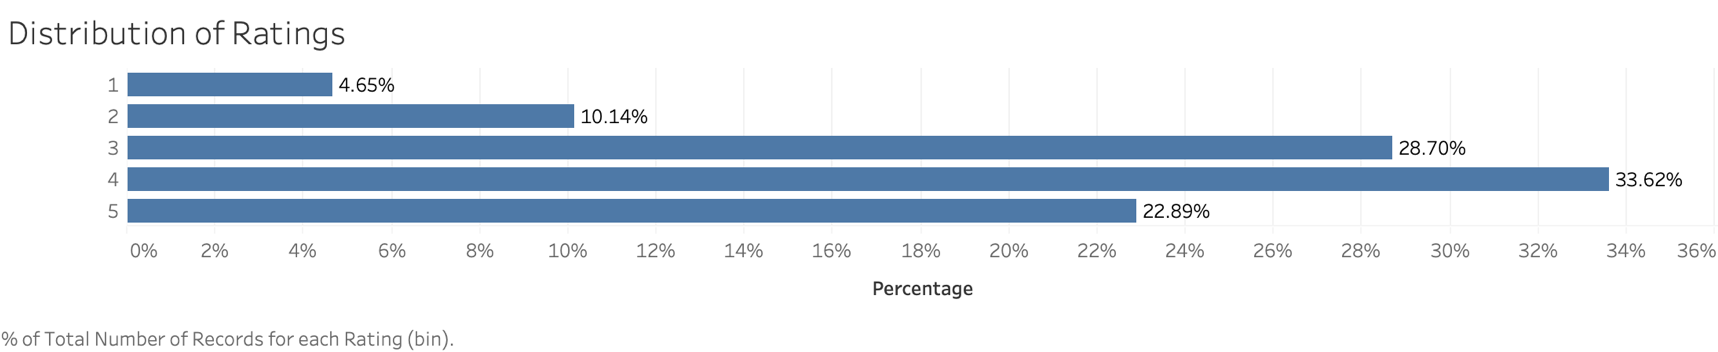

In [10]:
img1 = Image.open('EDA/Distribution of Movie Ratings.png')  
img1

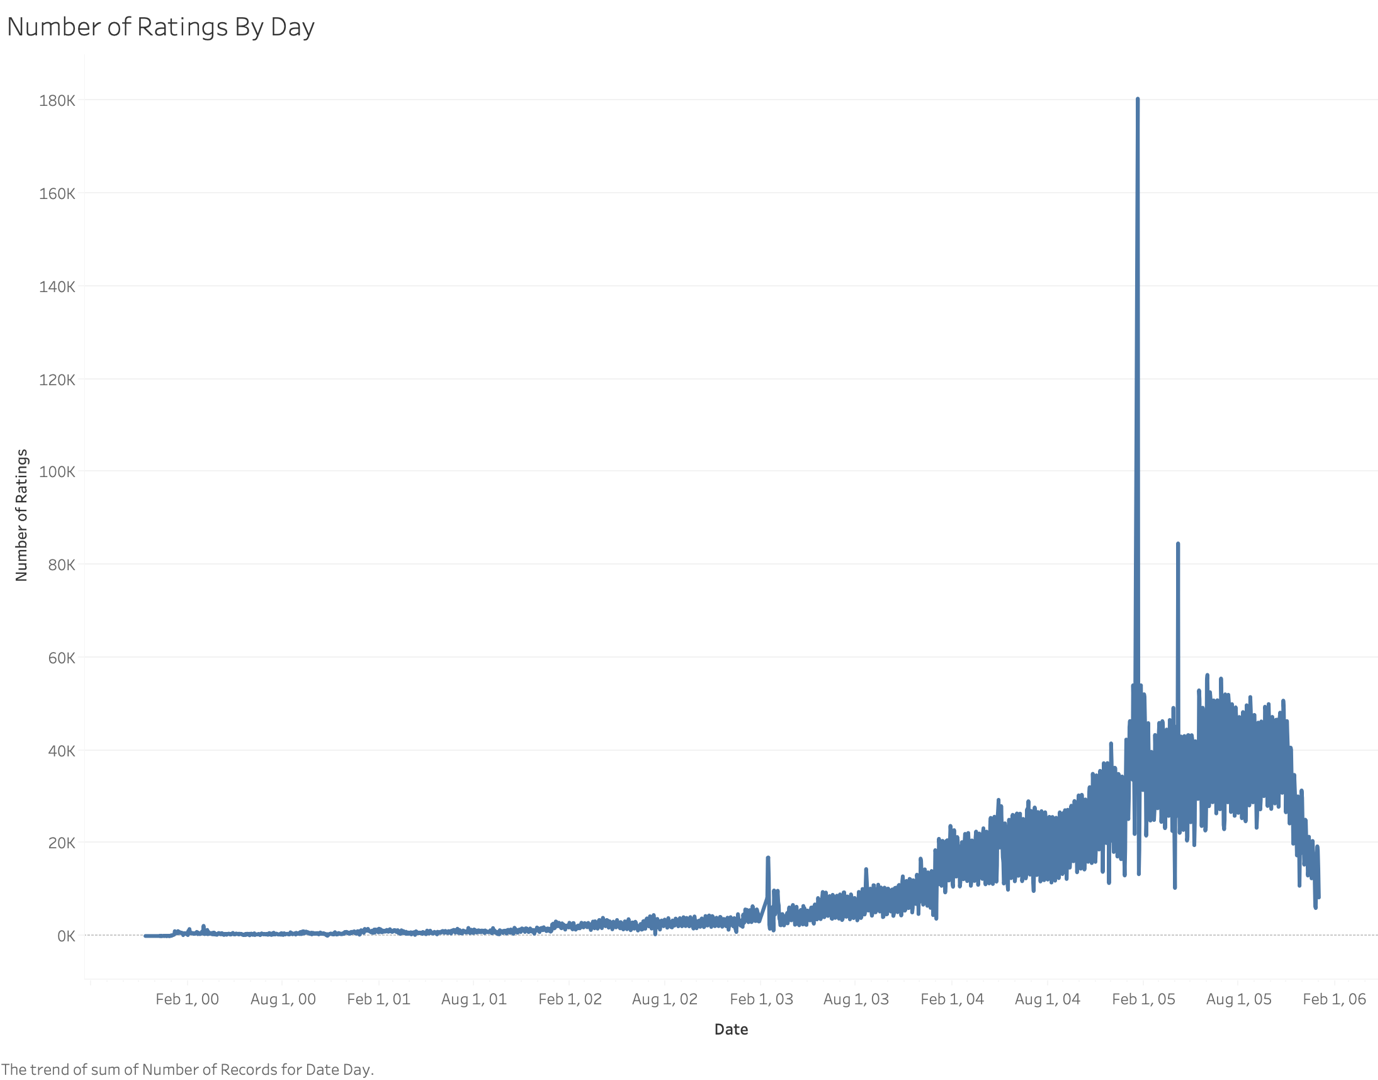

In [11]:
img2 = Image.open('EDA/Number of Movie Ratings Grouped By Day.png')  
img2

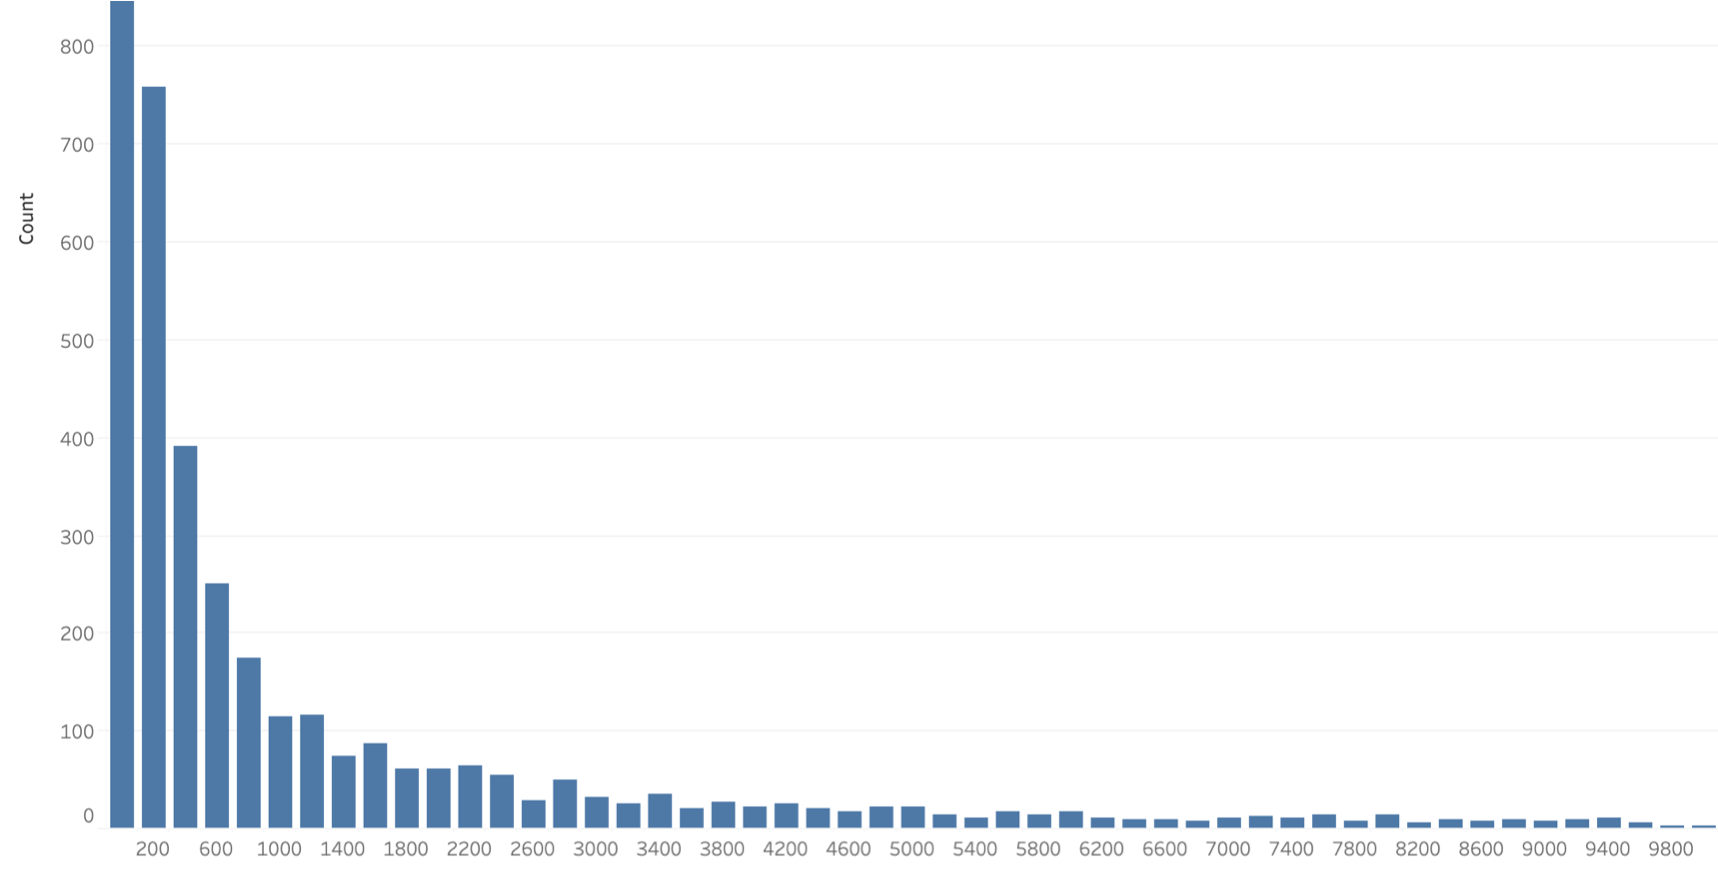

In [12]:
img3 = Image.open('EDA/Ratings Per Movie.png')  
img3

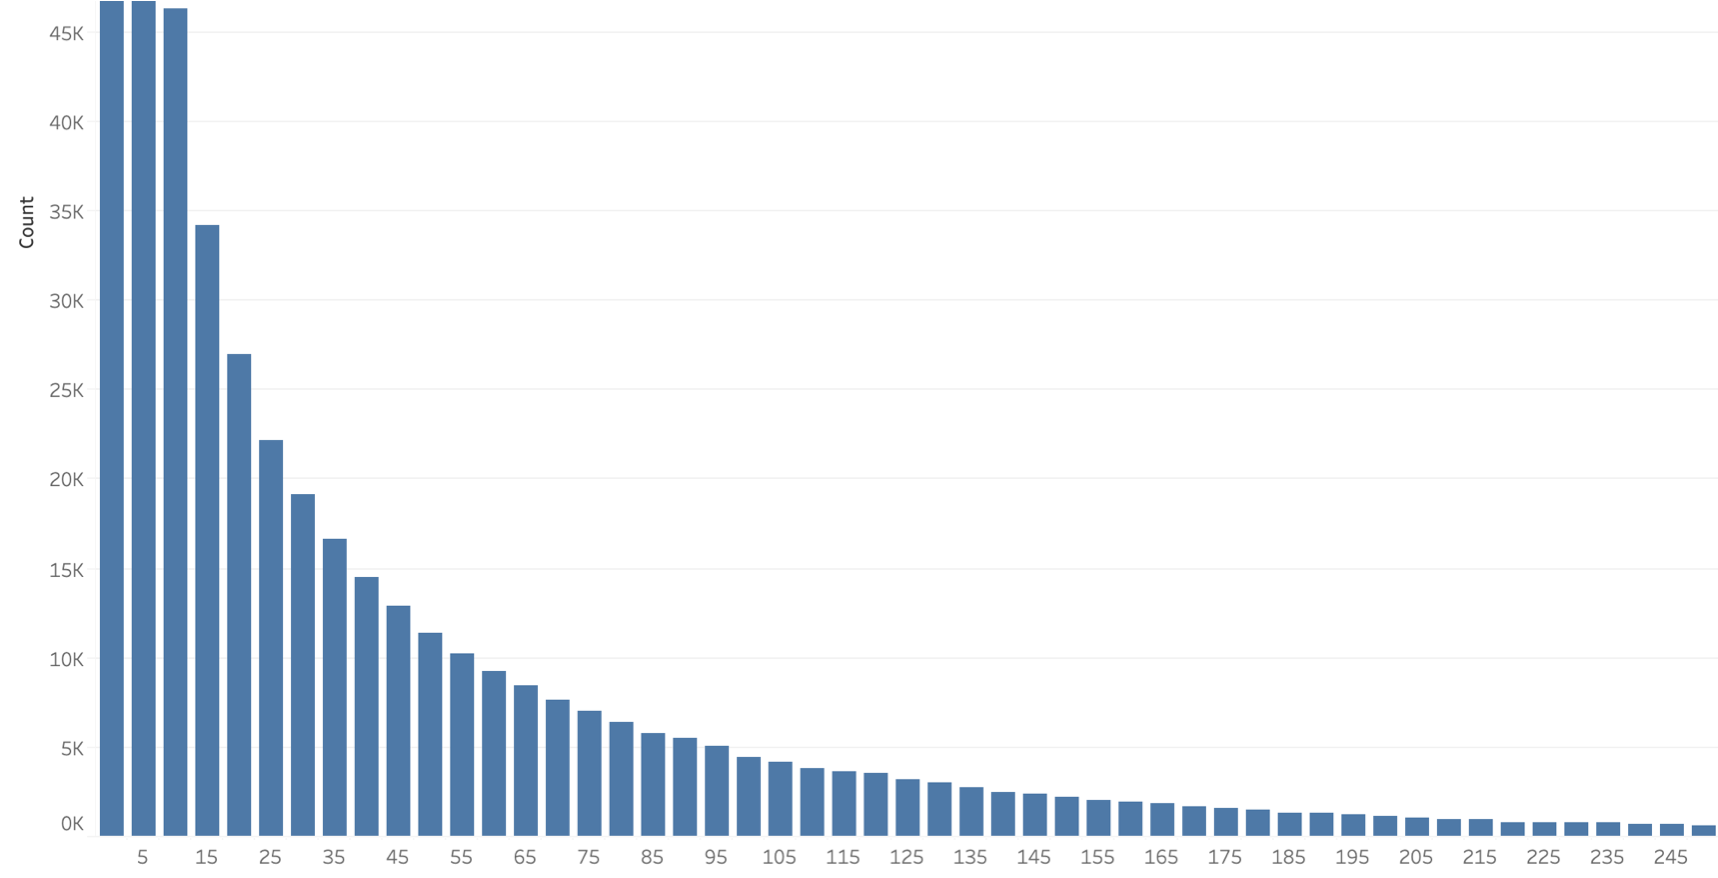

In [13]:
img4 = Image.open('EDA/Ratings Per User.png')  
img4

#### Here we are filtering out movies with few ratings and users who rarely rate
##### Play with filter number currently 5000 & 400

In [14]:
# Filter sparse movies
filter_movies = (training['movie_id'].value_counts()>5000)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
filter_users = (training['user_id'].value_counts()>400)
filter_users = filter_users[filter_users].index.tolist()

training_filterd = training[(training['movie_id'].isin(filter_movies)) & (training['user_id'].isin(filter_users))]
training_filterd = training_filterd.drop('date', axis=1).sample(frac=1).reset_index(drop=True)

print('unfiltered:\t{}'.format(training.shape))
print('filtered:\t{}'.format(training_filterd.shape))

unfiltered:	(24053764, 4)
filtered:	(939490, 3)


In [15]:
# Training take 70% of data. split here to calculate RMSE later
n = round(939490 * 0.7)
X_train = training_filterd[:n]
X_test = training_filterd[n:]

In [16]:
matrix_train = X_train.pivot_table(index='user_id', columns='movie_id', values='rating')
print(matrix_train.shape)
matrix_train.sample(5)

(2607, 774)


movie_id,8,17,18,26,28,30,33,44,46,52,...,4432,4454,4465,4472,4479,4488,4490,4492,4493,4496
user_id,,,,,,,,,,,,,,,,,,,,,
2356911,5.0,NaN,NaN,3.0,4.0,4.0,NaN,5.0,NaN,NaN,...,NaN,4.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN
1002367,3.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,3.0,3.0,NaN,NaN,4.0
1556831,NaN,NaN,2.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,...,1.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2314956,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
1849541,NaN,3.0,NaN,NaN,NaN,3.0,4.0,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN


## Models

#### There are several popular algorithms for recommendation engines
#### 1. Popularity: 
Recommend most popular movies to a user. This is best suitable for users that have not rated any movies and we are going to learn the user. In our case, we calculate the top 10 highest rating movies and return to the user. This algorithm is simple.  We going to do it, but this is not our focus.
#### 2. Collaborative Filtering Memory-Based. User-based & Item Based
We created the matrix to perform this technique.
2 most popular algorithms: Cosine User-User Similiarity & Pearson Correlation
#### 3. Collaborative filtering Model-Based.
Matrix Factorization and SVD is the most popular one. 
#### 4. Content-based filtering
given the dataset we have, only information we know about the movies is name and release year. So no point to do this technique.

#### JOBS TO DO
Popularity

CF User-based Cosine & Pearson (too many users cost high computation cost, may dispense)

CF Item-based Cosine & Pearson

CF SVD


### Popularity: Top 10 Highest rated ( Normal Mean / Weigted Mean)

In [17]:
# Normal mean

#get mean rating for each movie
mean_rating = matrix_train.mean(axis=0).sort_values(ascending=False).rename('mean_rating').to_frame()
#count how many ratings a movie got
rating_count = matrix_train.count(axis=0).rename('rating_count').to_frame()

#top 10 based on mean rating to recommend to users
top10_nm = mean_rating.head(10).join(rating_count).join(movie_titles)


# evaluate this method with RMSE
predict_df = X_test.set_index('movie_id').join(mean_rating)[['rating', 'mean_rating']]
rmse = np.sqrt(mean_squared_error(y_true = predict_df['rating'], y_pred = predict_df['mean_rating']))

print("RMSE for mean rating:", rmse)
top10_nm

RMSE for mean rating: 1.042270889772855


,mean_rating,rating_count,year,name
movie_id,,,,
3456,4.505556,180,2004.0,Lost: Season 1
2452,4.410999,1691,2001.0,Lord of the Rings: The Fellowship of the Ring
3962,4.357687,1574,2003.0,Finding Nemo (Widescreen)
4306,4.335556,1800,1999.0,The Sixth Sense
2102,4.327044,477,1994.0,The Simpsons: Season 6
2862,4.318052,1745,1991.0,The Silence of the Lambs
3290,4.279101,1469,1974.0,The Godfather
2172,4.264242,825,1991.0,The Simpsons: Season 3
2782,4.262638,1721,1995.0,Braveheart


In [18]:
# Weighted Mean
# weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
# R = average for the movie (mean) = (Rating)
# v = number of votes for the movie = (votes)
# m = minimum votes required to be listed in the Top 10
# C = the mean vote across the whole report

m = 500
c = matrix_train.stack().mean()
# user_id  movie_id
# 1000079  28          2.0
#          30          4.0
#          143         3.0
#          273         2.0
#          275         3.0
v = matrix_train.count().values
r = matrix_train.mean(axis=0).values #v,r list of 774 values

weighted_rating = (v/ (v+m) *r) + (m/ (v+m) *c)

# map weighted rating to movei_id, movie name and take top 10

# get index of sorted ratings
# [1 2 5 0 4 3 6] arg sort result
# [0 1 1 2 4 5 9]
ranking = np.argsort(weighted_rating)[::-1]
# use the index to find movie_ids in matrix columns. id's in order now
movie_id_sorted = matrix_train.columns[ranking]
# Sort rating in descending order
weighted_rating = np.sort(weighted_rating)[::-1]


# take top 10 of the ratings with top 10 movie ids
top10_ = pd.DataFrame(weighted_rating[:10], columns = ["mean_rating"])
top10_.index=movie_id_sorted[:10]
top10_wm = top10_.join(rating_count).join(movie_titles)



predict_df_w = X_test.set_index('movie_id').join(pd.DataFrame(weighted_rating,
                                                             index=matrix_train.columns,
                                                             columns=['prediction']))[['rating', 'prediction']]

rmse = np.sqrt(mean_squared_error(y_true = predict_df_w['rating'], y_pred = predict_df_w['prediction']))

print("RMSE for weighted mean rating:", rmse)
top10_wm

RMSE for weighted mean rating: 1.1240037898850497


,mean_rating,rating_count,year,name
movie_id,,,,
2452,4.177325,1691,2001.0,Lord of the Rings: The Fellowship of the Ring
4306,4.129356,1800,1999.0,The Sixth Sense
3962,4.123684,1574,2003.0,Finding Nemo (Widescreen)
2862,4.110699,1745,1991.0,The Silence of the Lambs
2782,4.065520,1721,1995.0,Braveheart
3290,4.052575,1469,1974.0,The Godfather
1905,4.001993,1768,2003.0,Pirates of the Caribbean: The Curse of the Bla...
3864,3.988522,1110,2005.0,Batman Begins
3079,3.959099,1321,1994.0,The Lion King: Special Edition


### Collaborative Filtering (Neighborhood method KNN with cosine & pearson similarity)

In [19]:
#KNN item-based with cosine similarity
data_all = training_filterd
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(data_all[['user_id', 'movie_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)

sim_options = { 'name': 'cosine' ,'user_based':  False}

algo = KNNBasic(sim_options = sim_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=True)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9470  0.9469  0.9448  0.9463  0.0010  
Fit time          8.55    6.17    5.33    6.68    1.37    
Test time         88.08   82.63   82.59   84.43   2.58    
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9440


0.9440043463397665

In [20]:
#KNN item-based with Pearson similarity
sim_options = { 'name': 'Pearson' ,'user_based':  False}

algo = KNNBasic(sim_options = sim_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=True)
predictions = algo.fit(trainset).test(testset)

accuracy.rmse(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9052  0.9055  0.9047  0.9051  0.0003  
Fit time          7.37    7.82    7.99    7.73    0.26    
Test time         82.44   82.36   80.68   81.83   0.81    
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8978


0.8977741930634464

In [21]:
top_recs = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
    top_recs[uid].append((iid, est))

for uid, user_ratings in top_recs.items():
    user_ratings.sort(key = lambda x: x[1], reverse = True)
    top_recs[uid] = user_ratings[:10]

def give_recs(user):
    temp = pd.DataFrame(top_recs[user], columns = ['movie_id', 'pred_rating'])
    return pd.merge(temp, movie_titles, on='movie_id')
give_recs('828444') 

,movie_id,pred_rating,year,name
0,798,4.289001,1975.0,Jaws
1,3290,3.987688,1974.0,The Godfather
2,2040,3.880138,1991.0,Star Trek: The Next Generation: Season 5
3,1495,3.863584,2001.0,Alias: Season 1
4,1370,3.828868,1976.0,Marathon Man
5,1324,3.812443,1994.0,The Professional
6,191,3.809576,2003.0,X2: X-Men United
7,331,3.765761,1997.0,Chasing Amy
8,3905,3.764524,2001.0,The Others
9,4306,3.722365,1999.0,The Sixth Sense


In [22]:
# user-based with pearson
sim_options = { 'name': 'Pearson' ,'user_based':  True}

algo = KNNBasic(sim_options = sim_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=True)
predictions = algo.fit(trainset).test(testset)

accuracy.rmse(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9788  0.9811  0.9809  0.9803  0.0010  
Fit time          47.06   48.57   48.01   47.88   0.62    
Test time         273.91  284.58  279.55  279.34  4.36    
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9736


0.9736165571629676

In [23]:
#user-based with cosine
sim_options = { 'name': 'Cosine' ,'user_based':  True}

algo = KNNBasic(sim_options = sim_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=True)
predictions = algo.fit(trainset).test(testset)

accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0454  1.0501  1.0463  1.0473  0.0020  
Fit time          40.16   41.45   41.68   41.10   0.67    
Test time         288.92  287.93  282.98  286.61  2.60    
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0491


1.0491418041316403

### Matrix Factorization with SVD

In [24]:
# Load dataset into surprise specific data-structure
data = sp.Dataset.load_from_df(training_filterd[['user_id', 'movie_id', 'rating']].sample(len(training_filterd)), sp.Reader())
param_grid = {'n_factors': [25, 30, 35, 40, 100], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008], 'reg_all': [0.08, 0.1, 0.15, 0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data) 
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse']) 
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params 
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs'] 
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

# trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

0.8344601063887295
{'n_factors': 25, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.02}
RMSE: 0.8278


0.8278099731945705

In [25]:
top_recs = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
    top_recs[uid].append((iid, est))

for uid, user_ratings in top_recs.items():
    user_ratings.sort(key = lambda x: x[1], reverse = True)
    top_recs[uid] = user_ratings[:10]

def give_recs(user):
    temp = pd.DataFrame(top_recs[user], columns = ['movie_id', 'pred_rating'])
    return pd.merge(temp, movie_titles, on='movie_id')
give_recs('828444') 

,movie_id,pred_rating,year,name
0,798,5.000000,1975.0,Jaws
1,3290,4.956075,1974.0,The Godfather
2,2162,4.730571,2000.0,CSI: Season 1
3,4306,4.703170,1999.0,The Sixth Sense
4,191,4.646403,2003.0,X2: X-Men United
5,2795,4.599780,2001.0,The X-Files: Season 9
6,2040,4.505479,1991.0,Star Trek: The Next Generation: Season 5
7,3079,4.387147,1994.0,The Lion King: Special Edition
8,3938,4.375411,2004.0,Shrek 2
9,4392,4.362851,1993.0,Army of Darkness
